In [8]:
import numpy as np
import networkx as nx
from scipy.linalg import solve
import matplotlib.pyplot as plt
from numpy.linalg import eig
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import numpy.linalg as LA

# Plotting defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 80

### Situation 1: 2 shortcuts both starting from node 1

In [9]:
def setup_matrix(L1, N, source1=0, source2=None, L2=None, secondshort=False):
    '''
    Set up an adjacency matrix A for the undirected nearest-neighbor 
    graph with N nodes and one shortcut from node 1 to node L.
    Inputs:
    - L1: shortcut end node.
    - N: number of nodes.
    - source1: source node for shortcut, default=0.
    - source2: source node for an optional 2nd shortcut.
    - L2: optional 2nd shortcut end node.
    - secondshort: boolean indicating whether a second shortcut
    is requied, default: False
    Outputs:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    '''
    A = np.zeros((N, N))
    
    for i in range(N-1):
        A[i, i+1] = 1
        A[i+1, i] = 1
    A[source1, L1-1] = 1
    A[0, -1] = 1
    A[-1, 0] = 1
    
    D = 2 * np.eye(N)
    
    S = np.copy(A)
    S[source1, L1-1] = 0
    
    if secondshort == True:
        A[source2, L2-1] = 1
        S[source2, L2-1] = 0
    
    return A, D, S

def spec_rad(A):
    '''
    Calculates the spectral radius of adjacency matrix A.
    Input:
    - A: adjacency matrix.
    Output:
    - spectral radius of matrix A.
    '''
    eigs = eig(A)[0]
    return max(abs(eigs))

def Katz(alpha, A, L=None, normed=False, approx=False):
    '''
    Calculates Katz centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of Katz centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether the approximation parameters
    for the modified ring are requested, default: False.
    Outputs:
    - centrality: Katz centrality.
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    Aa = np.eye(N) - alpha*A
    rhs = np.ones(N)
    centrality = solve(Aa, rhs)
    if normed == True:
        centrality /= LA.norm(centrality, 1) 
    
    if approx==True:
     
        # Roots
        t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
        t2 = (1 + np.sqrt(1 - 4*alpha**2)) / (2*alpha)
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[1 - 2*alpha*t1 - alpha*t1**(L-1), 1 - 2*alpha*t2 - alpha*t2**(L-1)],
                     [t1**(N/2-1) * (t1-2*alpha), t2**(N/2-1) * (t2-2*alpha)]])
        right = np.array([[alpha / (1 - 2*alpha)],[0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return centrality, t1, t2, h1, h2
    else:
        return centrality

def NBTW_spec_rad(A, D, S):
    '''
    Calculates the spectral radius of the companion linearization
    of the reversal matrix polynomial of matrix polynomial 
    M(t) = I - At + (D-I)t^2 + (A-S)t^3. Named: C.
    Input:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    Output:
    - spectral radius of matrix C.
    '''
    N = len(A)
    # Create matrix C
    C = np.zeros((3*N, 3*N))
    C[0: N, 0: N] = A
    C[0: N, N: 2*N] = np.eye(N) - D
    C[0: N, 2*N: 3*N] = S - A
    C[N: 2*N, 0: N] = np.eye(N)
    C[2*N: 3*N, N: 2*N] = np.eye(N)
    
    eigs = eig(C)[0]
    return max(abs(eigs))

def NBTW(alpha, A, D, S, L=None, normed=False, approx=False):
    '''
    Calculates NBTW centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of NBTW centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - D: diagonal degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether or not the approximation 
    parameters for the modified ring are requested, default: False.
    Outputs:
    - NBTWcentrality: NBTW centrality
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    
    # deformed graph Laplacian:
    M = np.eye(N) - A*alpha + (D-np.eye(N))*alpha**2  + (A-S)*alpha**3 
    
    rhs = (1-alpha**2) * np.ones(N)
    NBTWcentrality = solve(M, rhs)
    if normed == True:
        NBTWcentrality /= LA.norm(NBTWcentrality, 1) 
    
    if approx==True:
        # Roots
        t1 = alpha
        t2 = 1 / alpha
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[-alpha**2 + 1 + (alpha**2-1)*alpha**L, -1 + alpha**2 + (alpha**2-1)*alpha**(2-L)], 
                     [(alpha**2 - 1) * alpha**(N/2), -2*alpha**(2 - N/2) + (1 + alpha**2)*alpha**(-N/2)]])
        right = np.array([[alpha * (alpha+1)**2], [0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return NBTWcentrality, t1, t2, h1, h2
    else:
        return NBTWcentrality

def create_graph(A, nodesize, node_color, pos=None, circular=True, with_labels=True, arrows=True):
    '''
    Plots the graph associated with adjacency matrix A. 
    Inputs:
    - A: adjacency matrix
    - nodesize: list indicating the sizes of the nodes,
    typically the centrality vector.
    - node_color: list indicating the color for each node,
    typically the centrality vector.
    - pos: dictionary containing the positions of the 
    nodes. Only necessary when not dealing with a circular
    graph.
    - circular: boolean indicating whether or not a circular
    graph is required, default: True
    - with_labels: boolean indicating whether or not labels
    should be included with the nodes, default: True
    - arrows: boolean indicating whether the edges should 
    include arrows or not, default: True
    '''
    N = len(A)
    
    G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
    labeldict = {}
    for i in range(N):
        labeldict[i] = i+1
        
    nodelist = [i for i in range(N)]
        
    if circular == True:
        nx.draw_circular(G, 
                         labels=labeldict, 
                         node_size=nodesize, 
                         node_color=node_color,
                         font_color='white',
                         nodelist=nodelist,
                         with_labels=with_labels,
                         arrows=arrows)
    else:
        nx.draw(G, 
                labels=labeldict, 
                node_size=nodesize, 
                node_color=node_color,
                font_color='white',
                pos=pos,
                nodelist=nodelist,
                with_labels=with_labels,
                arrows=arrows)   

In [13]:
L1 = 8
L2 = 12
N = 20
percentage  = 0.6
A1, D, S = setup_matrix_1(L1, L2, N)

spec_rad1 = spec_rad(A1)
alpha = percentage / spec_rad1                           # take ...% of upper limit
KatzC = Katz(alpha, A1, normed=True)

spec_rad2 = NBTW_spec_rad(A1, D, S)
t = percentage / spec_rad2                                # take ...% of upper limit
NBTWC = NBTW(t, A1, D, S, normed=True)

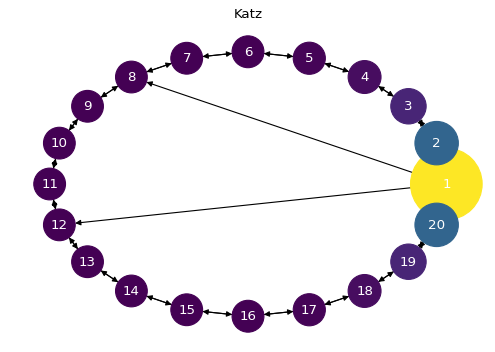

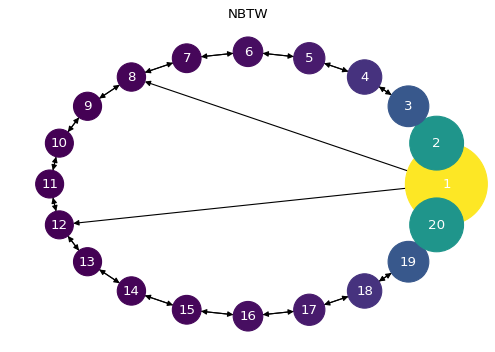

In [14]:
G = nx.from_numpy_matrix(A1, create_using=nx.MultiDiGraph)

# change first label to 1 instead of 0
labeldict = {}
for i in range(N):
    labeldict[i] = i+1

nx.draw_circular(G, labels=labeldict, 
                 node_size = (KatzC*200)**3, 
                 node_color = KatzC,
                 #cmap = 'cividis',
                 #alpha=0.8
                 font_color='white'
                )
plt.title('Katz')
plt.show()

nx.draw_circular(G, labels=labeldict, 
                 node_size = (NBTWC*200)**3, 
                 node_color = NBTWC, 
                 #alpha = 0.75,
                 font_color='white'
                )
plt.title('NBTW')
plt.show()

### Situation 2: both nodes with a different starting and ending position

In [24]:
a1 = 1
L1 = 13
a2 = 5
L2 = 19
N = 20
percentage  = 0.6
A2, D, S = setup_matrix(L1, N, a1, a2, L2, secondshort=True)

spec_rad1 = spec_rad(A2)
alpha = percentage / spec_rad1                           # take ...% of upper limit
KatzC = Katz(alpha, A2, normed=True)

spec_rad2 = NBTW_spec_rad(A2, D, S)
t = percentage / spec_rad2                                # take ...% of upper limit
NBTWC = NBTW(t, A2, D, S, normed=True)

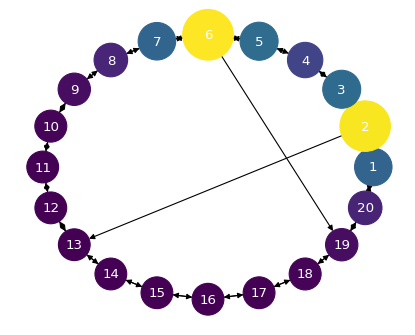

0.05214626797066427 0.05270236602940824


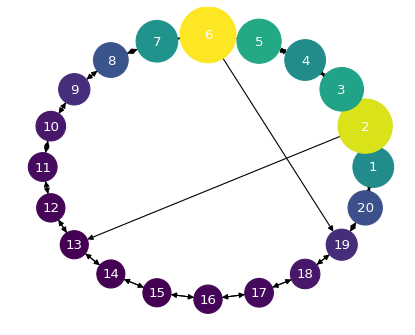

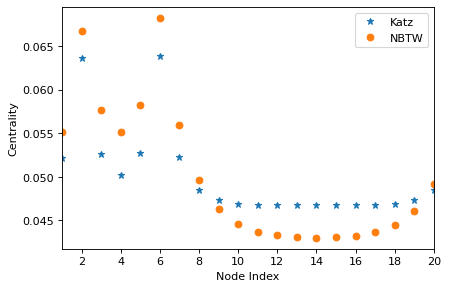

In [25]:
G = nx.from_numpy_matrix(A2, create_using=nx.MultiDiGraph)

# change first label to 1 instead of 0
labeldict = {}
for i in range(N):
    labeldict[i] = i+1
    
plt.figure(figsize=(5,4))
nx.draw_circular(G, labels=labeldict, 
                 node_size = (KatzC*200)**3, 
                 node_color = KatzC,
                 #cmap = 'cividis',
                 #alpha=0.8
                 font_color='white'
                )
# plt.title('Katz')
plt.savefig('multipleShortcutKatz{}.pdf'.format(percentage*100))
plt.show()
print(KatzC[a1-1], KatzC[a2-1])

plt.figure(figsize=(5,4))
nx.draw_circular(G, labels=labeldict, 
                 node_size = (NBTWC*200)**3, 
                 node_color = NBTWC, 
                 #alpha = 0.75,
                 font_color='white'
                )
# plt.title('NBTW')
plt.savefig('multipleShortcutNBTW{}.pdf'.format(percentage*100))
plt.show()


fig, ax = plt.subplots()
plt.plot(range(1, N+1), KatzC, '*', label='Katz')
plt.plot(range(1, N+1), NBTWC, 'o', label='NBTW')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Node Index')
plt.xlim([1,20])
plt.ylabel('Centrality')
plt.legend()
plt.savefig('multipleShortcutPlot{}.pdf'.format(percentage*100))
plt.show()